In [276]:
# !pip install sranodec

In [277]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

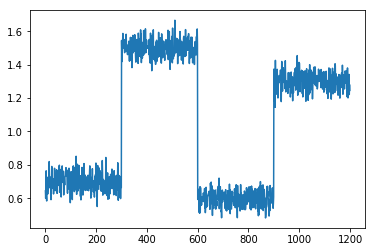

In [278]:
# Generate test data
test_signal = np.concatenate(
    [np.random.normal(0.7, 0.05, 300), 
     np.random.normal(1.5, 0.05, 300),
     np.random.normal(0.6, 0.05, 300),
     np.random.normal(1.3, 0.05, 300)])
plt.plot(test_signal)

In [279]:
import sranodec as anom

In [280]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

In [281]:
spec = anom.Silency(amp_window_size, series_window_size, score_window_size)


/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


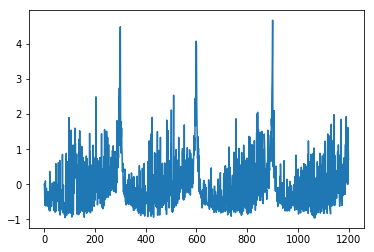

In [282]:
score = spec.generate_anomaly_score(test_signal)
plt.plot(score)

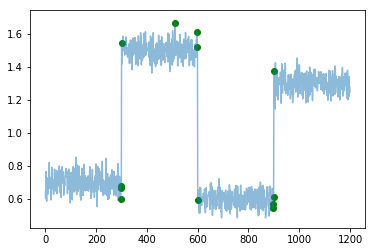

In [283]:

# Plot data with estimated anomalous points
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
plt.scatter(index_changes, test_signal[index_changes], c='green', label="change point")

# Read Data

In [284]:
# !pip install -r requirements.txt

In [285]:
# !pip install git+https://github.com/haowen-xu/tfsnippet.git@v0.2.0-alpha1

In [286]:
import pandas as pd

In [287]:
# -*- coding: utf-8 -*-
import logging
import os
import pickle
import sys
import time
import warnings
from argparse import ArgumentParser
from pprint import pformat, pprint

import numpy as np
import tensorflow as tf
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from tfsnippet.examples.utils import MLResults, print_with_title
from tfsnippet.scaffold import VariableSaver
from tfsnippet.utils import get_variables_as_dict, register_config_arguments, Config

from omni_anomaly.eval_methods import pot_eval, bf_search
from omni_anomaly.model import OmniAnomaly
from omni_anomaly.prediction import Predictor
from omni_anomaly.training import Trainer
from omni_anomaly.utils import get_data_dim, get_data, save_z, preprocess

In [288]:
prefix = 'DerbysoftServerMachineDataset/'
train_dir = 'train/'
test_dir = 'test/'
file_name = 'derbysoft_server_machine.csv'


In [289]:
train_df = pd.read_csv(prefix+train_dir+file_name, index_col=0)
train_df.index = pd.to_datetime(train_df.index)

In [290]:
model_list = list(train_df.columns)
model_list

['hse_5xx_count_train_data',
 'hse_fail_rate_train_data',
 'hse_2xx_count_train_data',
 'hse_non_2xx_count_train_data',
 'hse_4xx_count_train_data',
 'hse_resp_time_train_data']

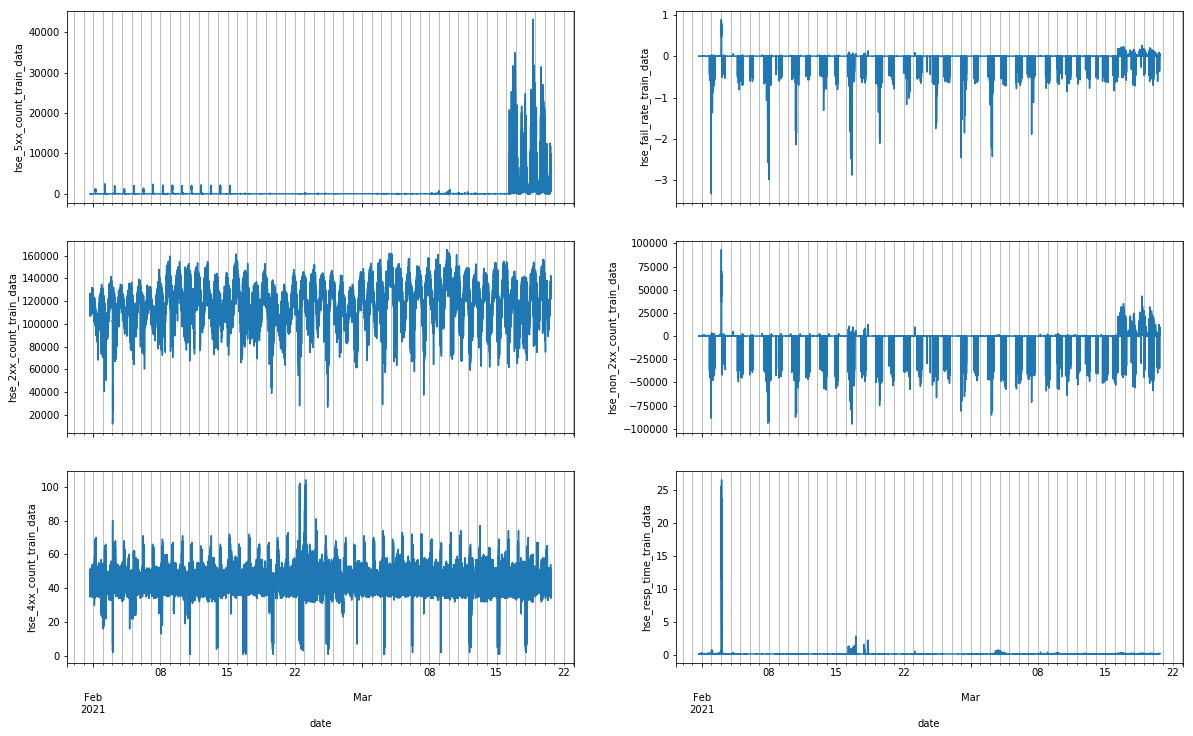

In [291]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):
    train_df[model_list[i]].loc["2021-01-01":"2021-05-07"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

In [292]:
class ExpConfig(Config):
    # dataset configuration
    dataset = "machine-1-1"
    x_dim = get_data_dim(dataset)

    # model architecture configuration
    use_connected_z_q = True
    use_connected_z_p = True

    # model parameters
    z_dim = 3
    rnn_cell = 'GRU'  # 'GRU', 'LSTM' or 'Basic'
    rnn_num_hidden = 500
    window_length = 100
    dense_dim = 500
    posterior_flow_type = 'nf'  # 'nf' or None
    nf_layers = 20  # for nf
    max_epoch = 10
    train_start = 0
    max_train_size = None  # `None` means full train set
    batch_size = 50
    l2_reg = 0.0001
    initial_lr = 0.001
    lr_anneal_factor = 0.5
    lr_anneal_epoch_freq = 40
    lr_anneal_step_freq = None
    std_epsilon = 1e-4

    # evaluation parameters
    test_n_z = 1
    test_batch_size = 50
    test_start = 0
    max_test_size = None  # `None` means full test set

    # the range and step-size for score for searching best-f1
    # may vary for different dataset
    bf_search_min = -400.
    bf_search_max = 400.
    bf_search_step_size = 1.

    valid_step_freq = 100
    gradient_clip_norm = 10.

    early_stop = True  # whether to apply early stop method

    # pot parameters
    # recommend values for `level`:
    # SMAP: 0.07
    # MSL: 0.01
    # SMD group 1: 0.0050
    # SMD group 2: 0.0075
    # SMD group 3: 0.0001
    level = 0.005

    # outputs config
    save_z = False  # whether to save sampled z in hidden space
    get_score_on_dim = False  # whether to get score on dim. If `True`, the score will be a 2-dim ndarray
    save_dir = 'model'
    restore_dir = None  # If not None, restore variables from this dir
    result_dir = 'result'  # Where to save the result file
    train_score_filename = 'train_score.pkl'
    test_score_filename = 'test_score.pkl'
    
    

In [293]:
# get config obj
config = ExpConfig()

# parse the arguments
# arg_parser = ArgumentParser()
# register_config_arguments(config, arg_parser)
# arg_parser.parse_args(sys.argv[1:])

config.max_epoch = 100
config.train_start = 20000
config.max_train_size = 10000
config.x_dim = train_df.shape[1]
config.restore_dir = 'model'

print_with_title('Configurations', pformat(config.to_dict()), after='\n')

# open the result object and prepare for result directories if specified
results = MLResults(config.result_dir)
results.save_config(config)  # save experiment settings for review
results.make_dirs(config.save_dir, exist_ok=True)
# with warnings.catch_warnings():
#     # suppress DeprecationWarning from NumPy caused by codes in TensorFlow-Probability
#     warnings.filterwarnings("ignore", category=DeprecationWarning, module='numpy')
#     main()

Configurations
{'batch_size': 50,
 'bf_search_max': 400.0,
 'bf_search_min': -400.0,
 'bf_search_step_size': 1.0,
 'dataset': 'machine-1-1',
 'dense_dim': 500,
 'early_stop': True,
 'get_score_on_dim': False,
 'gradient_clip_norm': 10.0,
 'initial_lr': 0.001,
 'l2_reg': 0.0001,
 'level': 0.005,
 'lr_anneal_epoch_freq': 40,
 'lr_anneal_factor': 0.5,
 'lr_anneal_step_freq': None,
 'max_epoch': 100,
 'max_test_size': None,
 'max_train_size': 10000,
 'nf_layers': 20,
 'posterior_flow_type': 'nf',
 'restore_dir': 'model',
 'result_dir': 'result',
 'rnn_cell': 'GRU',
 'rnn_num_hidden': 500,
 'save_dir': 'model',
 'save_z': False,
 'std_epsilon': 0.0001,
 'test_batch_size': 50,
 'test_n_z': 1,
 'test_score_filename': 'test_score.pkl',
 'test_start': 0,
 'train_score_filename': 'train_score.pkl',
 'train_start': 20000,
 'use_connected_z_p': True,
 'use_connected_z_q': True,
 'valid_step_freq': 100,
 'window_length': 100,
 'x_dim': 6,
 'z_dim': 3}



In [294]:
logging.basicConfig(
    level='INFO',
    format='%(asctime)s [%(levelname)s] %(name)s: %(message)s'
)

# # prepare the data
# (x_train, _), (x_test, y_test) = \
#     get_data(config.dataset, config.max_train_size, config.max_test_size, train_start=config.train_start,
#              test_start=config.test_start)

if config.max_train_size is None:
    train_end = None
else:
    train_end = config.train_start + config.max_train_size

train_data = train_df.values.reshape((-1, config.x_dim))[config.train_start:train_end, :]
x_train = preprocess(train_data)


Data normalized


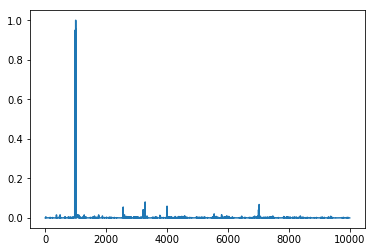

In [295]:
plt.plot(x_train[:,0])

In [296]:
import sranodec as anom

In [297]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

In [298]:
spec = anom.Silency(amp_window_size, series_window_size, score_window_size)


/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


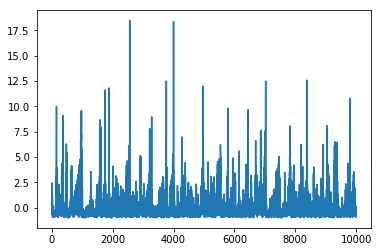

In [299]:
score = spec.generate_anomaly_score(x_train[:,0])
plt.plot(score)

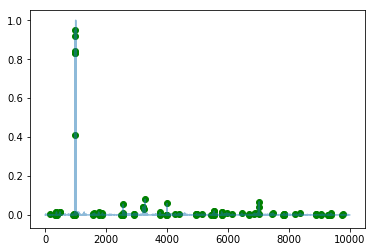

In [300]:
# Plot data with estimated anomalous points
plt.plot(x_train[:,0], alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
plt.scatter(index_changes, x_train[index_changes,0], c='green', label="change point")

In [301]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

spec = anom.Silency(amp_window_size, series_window_size, score_window_size)


In [302]:
model_list = list(train_df.columns)
model_list

['hse_5xx_count_train_data',
 'hse_fail_rate_train_data',
 'hse_2xx_count_train_data',
 'hse_non_2xx_count_train_data',
 'hse_4xx_count_train_data',
 'hse_resp_time_train_data']

/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: 

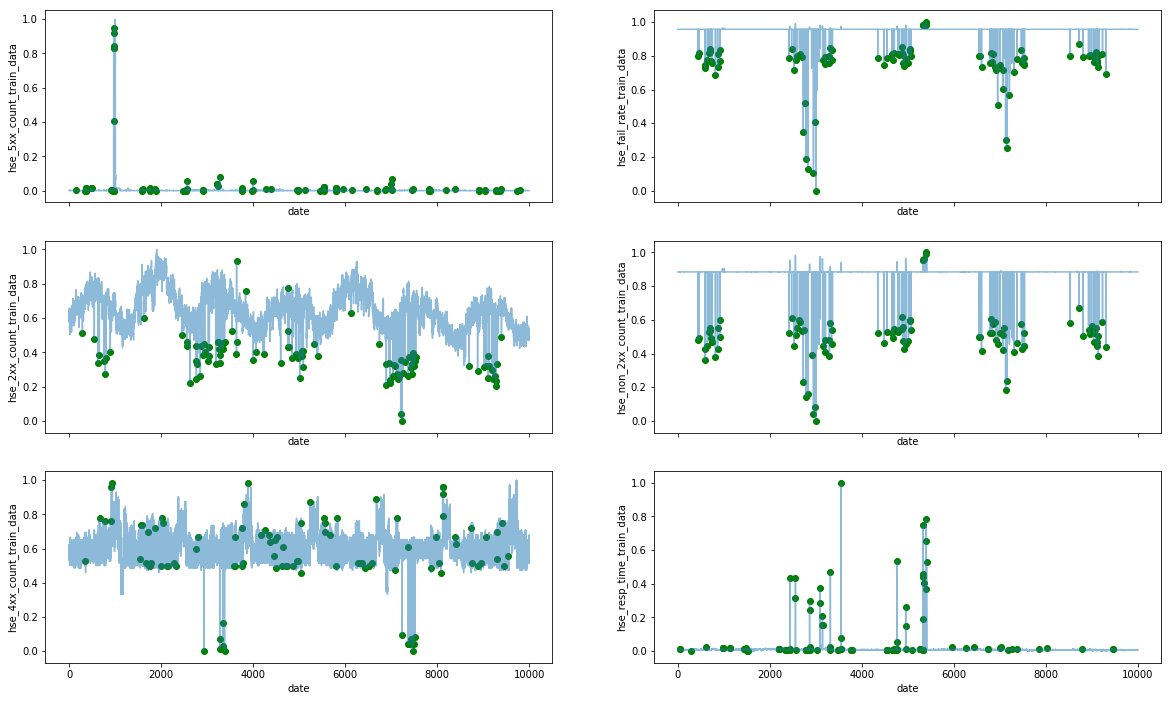

In [303]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):    
    score = spec.generate_anomaly_score(x_train[:,i])
    axx[i].plot(x_train[:,i], alpha=0.5, label="observation")
    index_changes = np.where(score > np.percentile(score, 99))[0]
    axx[i].scatter(index_changes, x_train[index_changes,i], c='green', label="change point")
#     axx[i].axvspan(2000, 3000, alpha=0.1, color='red')
#     print(len(index_changes))
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    

/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in true_divide
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/opt/conda/lib/python3.6/site-packages/sranodec/util.py:31: 

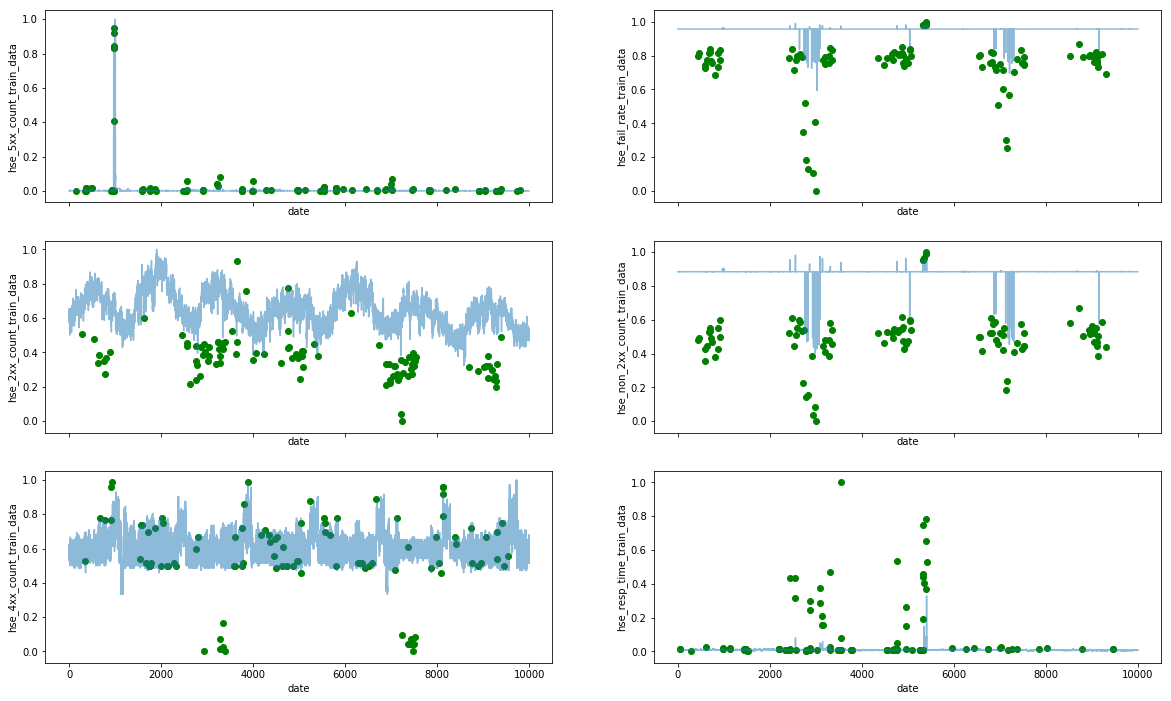

In [304]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), sharex=True)
axx = axs.ravel()
for i in range(0, len(model_list)):    
    score = spec.generate_anomaly_score(x_train[:,i])
    index_changes = np.where(score > np.percentile(score, 99))[0]
    axx[i].scatter(index_changes, x_train[index_changes,i], c='green', label="change point")

    x_train[index_changes,i] = np.nan
    df = pd.DataFrame(x_train[:,i])
    df = df.fillna(method="ffill")
#     df = df.fillna(0)
    x_train[:,i] = df.values.ravel()

    
    axx[i].plot(x_train[:,i], alpha=0.5, label="observation")

    
#     axx[i].axvspan(2000, 3000, alpha=0.1, color='red')
#     print(len(index_changes))
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel(model_list[i])   
    axx[i].grid(which='minor', axis='x')
    
    
    

In [305]:
df.values.ravel()

array([0.00856315, 0.00862452, 0.00882044, ..., 0.00724839, 0.00725509,
       0.00725509], dtype=float32)

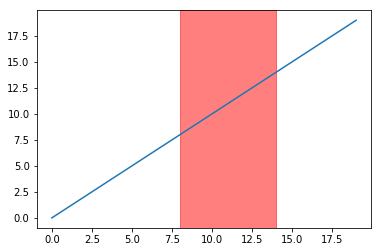

In [306]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(20))
ax.axvspan(8, 14, alpha=0.5, color='red')

plt.show()

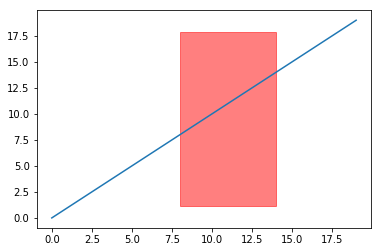

In [307]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(20))
ax.axvspan(8, 14, ymin=0.1, ymax=0.9, alpha=0.5, color='red')

plt.show()

In [308]:
arr = np.array([[np.nan, 1],[2,np.nan]])
arr

array([[nan,  1.],
       [ 2., nan]])

In [240]:
mask = np.isnan(arr)
idx = np.where(~mask,np.arange(mask.shape[1]),0)
np.maximum.accumulate(idx,axis=0, out=idx)
out = arr[np.arange(idx.shape[1])[:,None], idx]

In [241]:
out

array([[nan,  1.],
       [ 2., nan]])

In [242]:
mask.shape

(2, 2)

In [243]:
idx

array([[0, 1],
       [0, 1]])

In [309]:
import numpy as np

In [310]:
values = np.array([1,2,3,2,1])

In [312]:
freq = np.fft.fft(values)
print(freq)
mag = np.sqrt(freq.real ** 2 + freq.imag ** 2)
print(mag)
# spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))

# freq.real = freq.real * spectral_residual / mag
# freq.imag = freq.imag * spectral_residual / mag

# silency_map = np.fft.ifft(freq)

[ 9.        +0.j         -2.11803399-1.53884177j  0.11803399+0.36327126j
  0.11803399-0.36327126j -2.11803399+1.53884177j]
[9.         2.61803399 0.38196601 0.38196601 2.61803399]
